# ECG Beat Detector Comparison
## Important Variables
Important variables used throughout the code can be changed here.
- `segmentation_window_size`: every signal in a database is sliced into pieces of `segmentation_window_size` seconds to make the signals more comparable
- `tolerance_window_size`: to determine whether a QRS complex was determined correctly a tolerance window of ±`tolerance_window_size` milliseconds is used
- `print_detector_failure`: to decide whether a print should be shown if a detecor failes

In [1]:
segmentation_window_size = 10 # in seconds, default = 10
tolerance_window_size = 150 # in milliseconds, default = 150
print_detector_failure = 1 # print detector failure, 1 to print them, 0 to not print them, default = 0

## Import Libraries & Start Engines
Install all important libraries with pip apart from `matlab.engine` which has to be installed from the MATLAB root folder. You can find more information on instlaling the `matlab.engine` [here](https://de.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html)

In [2]:
import matlab.engine
import numpy as np
from cProfile import label
import matplotlib.pyplot as plt
import matplotlib
%matplotlib widget
import pathlib
from ecgdetectors import Detectors
import sys
import wfdb
from wfdb import processing
import pandas
import os
from detectors.visgraphdetector import VisGraphDetector

from os import listdir
from os.path import isfile, join
current_working_directory = os.getcwd()

import time
import neurokit2 as nk

Start the `matlab.engine` to be able to execute MATLAB commands or functions from within Python.

In [3]:
eng = matlab.engine.start_matlab()

## Define Classes and Functions
`Detector` class to store all values necessary for a detector. This can later be added to a list of `detectors`.

In [4]:
class Detector():
    def __init__(self, name, short_name, algorithm) -> None:
        self.name = name
        self.algorithm = algorithm
        self.short_name = short_name
    
    def predicted_qrs_compelx(self, signal, fs):
        return self.algorithm(signal, fs)

    def name(self):
        return self.name

    def short_name(self):
        return self.short_name

An `Evaluation` gets a `RecordingSegment` or `Recording` described below and the functions `predicted_peaks`, `binary_classification`, and `score_calculation`. The function `calculate` returns the whole element including `predicted_peaks`, number of predicted peaks `pp`, true positives `tp`, false positives `fp`, false negatives `fn`, `sensitivity`, `positive_predictivity`, and the `f1_score`.

In [5]:
class Evaluation():
    def __init__(self, RecordingSegment, Detector, predict_peaks, binary_classification, score_calculation) -> None:
        self.RecordingSegment = RecordingSegment
        self.Detector = Detector
        self.predict_peaks = predict_peaks
        self.binary_classification = binary_classification
        self.score_calculation = score_calculation
        self.predicted_peaks = None # predicted peaks as indexes
        self.runtime = 0
        self.pp = self.tp = self.fp = self.fn = None # number of predicted peaks, true positives, false positives, false negatives respectively
        self.sensitivity = self.positive_predictivity = self.f1_score = None
    
    def calculate(self):
        self.predicted_peaks, self.runtime = self.predict_peaks(self.RecordingSegment,self.Detector)
        self.runtime
        self.pp, self.tp, self.fp, self.fn = self.binary_classification(self.RecordingSegment, self.predicted_peaks)
        self.sensitivity, self.positive_predictivity, self.f1_score = self.score_calculation(self.tp, self.fp, self.fn)
        return self

`Database` class to store all values necessary for a databse. This can later be added to a list of `databases`.

In [6]:
class Database():
    def __init__(self, Name, Users, Fs) -> None:
        self.Name = Name
        self.Users = Users
        self.Fs = Fs

    def Name(self):
        return self.Name

    def Users(self):
        return self.Users

    def Fs(self):
        return self.Fs

Each `Database` stores a list of `Users`. This `User` class stores important information about a user and a list to `Recordings` this user took. `User` can here also be used if a database stores arrythmia and sinus rythm signals.

In [7]:
class User():
    def __init__(self, UserName,Recordings) -> None:
        self.UserName = UserName
        self.Recordings = Recordings

    def UserName(self):
        return self.UserName

    def Recordings(self):
        return self.Recordings

Each `User` stores a list of `Recordings`. This `Recording` class stores important information about a recording and a list to `RecordingSegments` created from the signal in `Recording`. `Recording` stores the whole unsplit signal and list of actual QRS complexes. 

In [8]:
class Recording():
    def __init__(self, RecordingName, RecordingSegments, WholeSignal, WholeActual_Qrs_Complex, Fs) -> None:
        self.RecordingName = RecordingName
        self.RecordingSegments = RecordingSegments
        self.WholeSignal = WholeSignal
        self.WholeActual_Qrs_Complex = WholeActual_Qrs_Complex
        self.Fs = Fs
        self.Evaluations = []

    def RecordingName(self):
        return self.RecordingName
    
    def RecordingSegments(self):
        return self.RecordingSegments

    def WholeSignal(self):
        return self.WholeSignal
    
    def WholeActual_Qrs_Complex(self):
        return self.WholeActual_Qrs_Complex

    def Fs(self):
        return self.Fs

    def Evaluation(self, detectors, predict_peaks, binary_classification, score_calculation):
        self.Evaluations = []
        for detector in detectors:
            self.Evaluations.append(Evaluation(self,detector,predict_peaks, binary_classification, score_calculation).calculate())
        return self.Evaluations

Each `Recording` stores a list of `RecordingSegments`. The `RecordingSegment` class stores important information about a segment of a recording. The function `Evaluation` which takes a list of `detectors` and three functions as an input returns a list of `Evaluation` objects, one for each detector.

In [9]:
class RecordingSegment():
    def __init__(self, Signal, Actual_Qrs_Complex, Fs) -> None:
        self.Signal = Signal
        self.Actual_Qrs_Complex = Actual_Qrs_Complex
        self.Fs = Fs
        self.Evaluations = []

    def Signal(self):
        return self.Signal

    def Actual_Qrs_Complex(self):
        return self.Actual_Qrs_Complex

    def Fs(self):
        return self.Fs

    def Evaluation(self, detectors, predict_peaks, binary_classification, score_calculation):
        self.Evaluations = []
        for detector in detectors:
            self.Evaluations.append(Evaluation(self,detector,predict_peaks, binary_classification, score_calculation).calculate())
        return self.Evaluations

This is a function to split signals in smaller parts including the respecitve qrs complexes. `split_signal` returns an array of arrays where the inner arrays store the signals and the qrs complexes and the outer array stores the inner arrays.

In [10]:
def split_signal(signal, fs, actual_qrs_complexes):
    signal = np.array(signal)
    actual_qrs_complexes = np.array(actual_qrs_complexes)
    split = [[] for i in range(((len(signal)//(fs*segmentation_window_size)*2)-1))]

    for split_signal_counter in range((len(signal)//(fs*segmentation_window_size)*2)-1):
        min_index = split_signal_counter*(fs*segmentation_window_size//2)
        max_index = split_signal_counter*(fs*segmentation_window_size//2)+fs*segmentation_window_size-1

        split[split_signal_counter].append(signal[min_index:max_index])

        min_counter = 0
        max_counter = 0

        for qrs_complex_counter in range(len(actual_qrs_complexes)):
            if actual_qrs_complexes[qrs_complex_counter] < min_index:
                min_counter += 1
            if actual_qrs_complexes[qrs_complex_counter] < max_index:
                max_counter += 1
        split[split_signal_counter].append(actual_qrs_complexes[min_counter:max_counter]-min_index)

    return split


## Create Database Objects
### Telehealth Database
Create a `Database` object for `telehealth_environment_database` including all sub objects necessary to initialize it.

In [11]:
telehealth_path = join(current_working_directory,'databases/telehealth')
telehealth_files = [f for f in listdir(telehealth_path) if isfile(join(telehealth_path, f))]

telehealth_fs = 500
users = []
recordings = []
for file in telehealth_files:
    recordingsegments = []
    data = pandas.read_csv(join(telehealth_path, file),sep=",",header=None)
    signal = np.array(data[0]).astype(float)
    qrs_complex_indices = np.array(data[1]).astype(int)
    actual_qrs_complexes = []
    
    for indexcounter in range(len(qrs_complex_indices)):
        if qrs_complex_indices[indexcounter]:
            actual_qrs_complexes.append(indexcounter)
    
    splits = split_signal(signal=signal,fs=telehealth_fs, actual_qrs_complexes=np.array(actual_qrs_complexes).astype(int))
    
    for split in splits:
        recordingsegments.append(RecordingSegment(Signal=split[0], Actual_Qrs_Complex=split[1], Fs=telehealth_fs))
    recordings.append(Recording(RecordingName=str(file),RecordingSegments = recordingsegments,WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=telehealth_fs))
users.append(User(UserName="default",Recordings = recordings))   
        
telehealth_environment_database = Database(
    Name="Telehealth Test Database",
    Users=users,
    Fs=telehealth_fs)

### Synthetic Database
Some initial parameters for the generation of the synthetic signals. Here it is possible to choose diffent types of artificial noise and also choose whether the signal should be real or synthetic.

In [12]:
# ---Initial parameters---
rrLength = 50       # A desired ECG signal length (the number of RR intervals) 
APBrate = 0.10      # Rate of atrial premature beats (APB). A number between 0 and 0.5
onlyRR = 0          # 1 - only RR intervals are generated, 0 - multilead ECG is generated

medEpis = 15        # Median duration of an atrial fibrillation (AF) episode
stayInAF = float(1-np.log(2)/medEpis)   # Probability to stay in AF state
AFburden = 0.8      # AF burden. 0 - the entire signal is sinus rhythm (SR), 1 - the entire signal is AF

noiseType = 4       # Type of noise. A number from 0 to 4. 0 - no noise added (noise RMS = 0 mV), 
                    # 1 - motion artefacts, 2 - electrode movement artefacts, 3 - baseline wander, 
                    # 4 - mixture of type 1, type 2 and type 3 noises
noiseRMS = 0.02     # Noise level in milivolts 

realRRon = 1        # 1 - real RR series are used, 0 - synthetic
realVAon = 1        # 1 - real ventricular activity is used, 0 - synthetic
realAAon = 1        # 1 - real atrial activity is used, 0 - synthetic
# Note: cannot select real atrial activity and synthetic ventricular activity

Generate a synthetic signal and safe it in `returndata`

In [13]:
signal_generator_path = eng.genpath('C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code\Signal_generator')
eng.addpath(signal_generator_path, nargout=0)

returndata = eng.simPAF_ECG_generator(rrLength, realRRon, realVAon, realAAon, AFburden, stayInAF, APBrate, noiseType, noiseRMS, onlyRR)

Create a `Database` object for `synth_database` including all sub objects necessary to initialize it.

In [14]:
synth_fs = 500
signal = np.transpose(np.array(returndata['multileadECG']))[:,0]
actual_qrs_complexes = np.transpose(np.array(returndata['QRSindex']))[:,0].astype(int)

splits = split_signal(signal=signal,fs=synth_fs,actual_qrs_complexes=actual_qrs_complexes)

recordingsegments = []
for split in splits:
    recordingsegments.append(RecordingSegment(Signal=split[0],Actual_Qrs_Complex=split[1],Fs=synth_fs))
recordings = [Recording("default",RecordingSegments=recordingsegments, WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=synth_fs)]
users = [User(UserName="default",Recordings=recordings)]

synth_database = Database(
    Name="Synthetic data", 
    Users=users,
    Fs=synth_fs)

### WFDB Test Database
Create a `Database` object for `wfdb_test_database` including all sub objects necessary to initialize it.

In [15]:
wfdb_fs = wfdb.rdrecord('sample-data/100', sampfrom=0, sampto=10000, channels=[0]).fs
signal = np.array(wfdb.rdrecord('sample-data/100', sampfrom=0, sampto=10000, channels=[0]).p_signal[:,0])
actual_qrs_complexes = np.array(wfdb.rdann('sample-data/100','atr', sampfrom=0, sampto=10000).sample[1:]).astype(int)

splits = split_signal(signal=signal, fs=wfdb_fs, actual_qrs_complexes=actual_qrs_complexes)

recordingsegments = []
for split in splits:
    recordingsegments.append(RecordingSegment(Signal=split[0],Actual_Qrs_Complex=split[1],Fs=wfdb_fs))
recordings = [Recording("default",RecordingSegments=recordingsegments, WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=wfdb_fs)]
users = [User(UserName="default",Recordings=recordings)]

wfdb_test_database = Database(
    Name="WFDB Test Database",
    Users=users,
    Fs=wfdb_fs)

### MIT-BIH Arrhythmia Database
Create a `Database` object for `mit_bih_arrhythmia_database` including all sub objects necessary to initialize it.

In [16]:
mit_bih_arrhythmia_path = "C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code\TestDatabases\mit-bih-arrhythmia-database-1.0.0"
files = np.array(pandas.read_csv(join(mit_bih_arrhythmia_path, "RECORDS"),header=None)[0])

mit_bih_arrhythmia_fs = wfdb.rdrecord(join(mit_bih_arrhythmia_path,str(files[0])), channels=[0]).fs

users = []

for file in files:
    recordings = []
    recordingsegments = []
    signal = np.array(wfdb.rdrecord(join(mit_bih_arrhythmia_path,str(file)), channels=[0]).p_signal[:,0]).astype(float)
    actual_qrs_complexes = np.array(wfdb.rdann(join(mit_bih_arrhythmia_path,str(file)),'atr').sample[1:]).astype(int)
    
    splits = split_signal(signal=signal,fs=mit_bih_arrhythmia_fs, actual_qrs_complexes=actual_qrs_complexes)
    
    for split in splits:
        recordingsegments.append(RecordingSegment(Signal=split[0], Actual_Qrs_Complex=split[1], Fs=mit_bih_arrhythmia_fs))
    recordings.append(Recording(RecordingName="default",RecordingSegments = recordingsegments,WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=mit_bih_arrhythmia_fs))
    users.append(User(UserName=str(file),Recordings = recordings))

mit_bih_arrhythmia_database = Database(
    Name="MIT-BIH Arrhythmia Database",
    Users=users,
    Fs=mit_bih_arrhythmia_fs)

## Create Detector Objects
Create `Detector` objects for detectors from different locations in the standaradized format.

Create `gqrs_detector` object. This detector stems from the wfdb toolbox. More information can be found online.

In [17]:
gqrs_detector = Detector(name="GQRS", short_name="gqrs", algorithm=processing.qrs.gqrs_detect)

Create `jqrs_detector` object. This detector is written in MATLAB and also executed via the MATLAB engine. Therefore a function has been written to get it into the right format. More information can be found in the respective file.

In [18]:
jqrs_algo_path = eng.genpath(join(current_working_directory,'detectors\jqrs'))
eng.addpath(jqrs_algo_path, nargout=0)

def run_jqrs_detector(signal, fs):
    threshold = 0.6 # energy threshold of the detector in au, default = 0.6
    ref_period = 0.250 # refractory period in sec between two R-peaks in ms, default = 0.250
    newsignal = [[i] for i in signal]
    return np.array(eng.qrs_detect2(matlab.double(newsignal), threshold, ref_period, matlab.double(fs)))[0].astype(int)

jqrs_detector = Detector(name="JQRS", short_name="jqrs", algorithm=run_jqrs_detector)

Create `visgraph_detector` object. For this detector a Python implementation is used. More information can be found in the respecitve file.

In [19]:
def run_visgraph_detector(signal, fs):
    beta = 0.55 # beta, default = 0.55
    gamma = 0.5 # gamm, default = 0.5
    lowcut = 4 # lowcut, default = 4
    R_peaks, weights, weighted_signal = VisGraphDetector(fs).visgraphdetect(signal, beta=beta, gamma=gamma, lowcut=lowcut, M = 2*fs)
    return R_peaks

visgraph_detector = Detector(name="VisGraphDetector", short_name="visgraph", algorithm=run_visgraph_detector)

Create `rpeakdetect_detector` object. This detector is written in MATLAB and also executed via the MATLAB engine. Therefore a function has been written to get it into the right format. More information can be found in the respective file.

In [20]:
rpeakdetect_path = eng.genpath(join(current_working_directory,'detectors'))
eng.addpath(rpeakdetect_path, nargout=0)

def run_rpeakdetect_detector(signal, fs):
    threshhold = 0.2 # default = 0.2
    testmode = 0 # default = 0
    newsignal = [[i] for i in signal]
    return np.array(eng.rpeakdetect(matlab.double(newsignal), matlab.double(fs),threshhold,testmode)['R_index'])[0].astype(int)

rpeakdetect_detector = Detector(name="rpeakdetect", short_name="rpeak", algorithm=run_rpeakdetect_detector)

Create `r_deco_detector` object. This detector is written in MATLAB and also executed via the MATLAB engine. Therefore a function has been written to get it into the right format. More information can be found in the respective file.

In [21]:
r_deco_path = eng.genpath(join(current_working_directory,'detectors/r_deco'))
eng.addpath(r_deco_path, nargout=0)

def run_r_deco_detector(signal, fs):
    envelope_size = 300.0 # envelope size in ms, default = 300.0
    average_heart_rate = 100.0 # average heart rate in bpm, default = 100.0
    post_processing = 1.0 # post processing where 1.0 means yes, default = 1.0
    ectopic_removal = 0.0 # ectopic removal where 1.0 means yes, default = 0.0
    inverted_signal = 0.0 # inverted signal where 1.0 means yes, default = 0.0
    parameters_check = 0.0 # parameters check in UI where 1.0 means yes, default = 0.0
    newsignal = [[i] for i in signal]
    return np.array(eng.peak_detection([envelope_size,average_heart_rate,post_processing,ectopic_removal,inverted_signal],matlab.double(newsignal), matlab.double(fs),parameters_check)).astype(int)[0][0]

r_deco_detector = Detector(name="r_deco", short_name="rdeco", algorithm=run_r_deco_detector)

Create `unsw_detector` object. This detector is written in MATLAB and also executed via the MATLAB engine. Therefore a function has been written to get it into the right format. More information can be found in the respective file.

In [22]:
unsw_path = eng.genpath(join(current_working_directory,'detectors/unsw'))
eng.addpath(unsw_path, nargout=0)

def run_unsw_detector(signal, fs):
    mask = [] # mask could be implemented later if wanted
    plotting = False # 1.0 for ploting intermediate signals, 0.0 for no plotting, default = 0.0
    newsignal = [[i] for i in signal]
    return np.array(eng.UNSW_QRSDetector(matlab.double(newsignal), matlab.double(fs),matlab.double(mask),bool(plotting))).astype(int)[0] #,matlab.double(mask),plotting)

unsw_detector = Detector(name="UNSW_QRSDetector", short_name="unsw", algorithm=run_unsw_detector)

Create functions to get the detectors from the `ecgdetectors` package into the right standard format. Additionally they are safed into their own objects. More information about the package can be found online.

In [23]:
def run_two_average_detector(signal, fs):
    return Detectors(fs).two_average_detector(unfiltered_ecg=signal)

two_average_detector = Detector(name="Elgendi et al (Two average)", short_name="two_avg", algorithm=run_two_average_detector)

def run_matched_filter_detector(signal, fs):
    return Detectors(fs).matched_filter_detector(unfiltered_ecg=signal)

matched_filter_detector = Detector(name="Matched filter", short_name="match_fil", algorithm=run_matched_filter_detector)

def run_swt_detector(signal, fs):
    return Detectors(fs).swt_detector(unfiltered_ecg=signal)

swt_detector = Detector(name="Kalidas & Tamil (Wavelet transform)", short_name="swt", algorithm=run_swt_detector)

def run_engzee_detector(signal, fs):
    return Detectors(fs).engzee_detector(unfiltered_ecg=signal)

engzee_detector = Detector(name="Engzee", short_name="engz", algorithm=run_engzee_detector)

def run_christov_detector(signal, fs):
    return Detectors(fs).christov_detector(unfiltered_ecg=signal)

christov_detector = Detector(name="Christov", short_name="christ", algorithm=run_christov_detector)

def run_hamilton_detector(signal, fs):
    return Detectors(fs).hamilton_detector(unfiltered_ecg=signal)

hamilton_detector = Detector(name="Hamilton", short_name="hamilt", algorithm=run_hamilton_detector)

def run_pan_tompkins_detector(signal, fs):
    return Detectors(fs).pan_tompkins_detector(unfiltered_ecg=signal)

pan_tompkins_detector = Detector(name="Pan Tompkins", short_name="pan_tomp", algorithm=run_pan_tompkins_detector)

def run_wqrs_detector(signal, fs):
    return Detectors(fs).wqrs_detector(unfiltered_ecg=signal)

wqrs_detector = Detector(name="WQRS", short_name="wqrs", algorithm=run_wqrs_detector)

Create functions to get the detectors from the `neurokit2` package into the right standard format. Additionally they are safed into their own objects. More information about the package can be found online.

In [24]:
def run_neurokit(signal, fs):
    # neurokit (default)
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="neurokit")
    _, neurokit = nk.ecg_peaks(cleaned, sampling_rate=fs, method="neurokit")
    return neurokit["ECG_R_Peaks"]

neurokit_detector = Detector(name="neurokit", short_name="nk", algorithm=run_neurokit)

def run_pantompkins1985(signal, fs):
    # pantompkins1985
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="pantompkins1985")
    _, pantompkins1985 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="pantompkins1985")
    return pantompkins1985["ECG_R_Peaks"]

pantompkins1985_detector = Detector(name="pantompkins1985", short_name="pan_tomp_nk", algorithm=run_pantompkins1985)

def run_nabian2018(signal, fs):
    # nabian2018
    _, nabian2018 = nk.ecg_peaks(signal, sampling_rate=fs, method="nabian2018")
    return nabian2018["ECG_R_Peaks"]

nabian2018_detector = Detector(name="nabian2018", short_name="nab_nk", algorithm=run_nabian2018)

def run_hamilton2002(signal, fs):
    # hamilton2002
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="hamilton2002")
    _, hamilton2002 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="hamilton2002")
    return hamilton2002["ECG_R_Peaks"]

hamilton2002_detector = Detector(name="hamilton2002", short_name="ham_nk", algorithm=run_hamilton2002)

def run_martinez2003(signal, fs):
    # martinez2003
    _, martinez2003 = nk.ecg_peaks(signal, sampling_rate=fs, method="martinez2003")
    return martinez2003["ECG_R_Peaks"]

martinez2003_detector = Detector(name="martinez2003", short_name="mart_nk", algorithm=run_martinez2003)

def run_zong2003(signal, fs):
    # zong2003
    _, zong2003 = nk.ecg_peaks(signal, sampling_rate=fs, method="zong2003")
    return zong2003["ECG_R_Peaks"]

zong2003_detector = Detector(name="zong2003", short_name="zong_nk", algorithm=run_zong2003)

def run_christov2004(signal, fs):
    # christov2004
    _, christov2004 = nk.ecg_peaks(signal, sampling_rate=fs, method="christov2004")
    return christov2004["ECG_R_Peaks"]

christov2004_detector = Detector(name="christov2004", short_name="chris_nk", algorithm=run_christov2004)

def run_gamboa2008(signal, fs):
    # gamboa2008
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="gamboa2008")
    _, gamboa2008 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="gamboa2008")
    return gamboa2008["ECG_R_Peaks"]

gamboa2008_detector = Detector(name="gamboa2008", short_name="gamb_nk", algorithm=run_gamboa2008)

def run_elgendi2010(signal, fs):
    # elgendi2010
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="elgendi2010")
    _, elgendi2010 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="elgendi2010")
    return elgendi2010["ECG_R_Peaks"]

elgendi2010_detector = Detector(name="elgendi2010", short_name="elg_nk", algorithm=run_elgendi2010)

def run_engzeemod2012(signal, fs):
    # engzeemod2012
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="engzeemod2012")
    _, engzeemod2012 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="engzeemod2012")
    return engzeemod2012["ECG_R_Peaks"]

engzeemod2012_detector = Detector(name="engzeemod2012", short_name="engz_nk", algorithm=run_engzeemod2012)

def run_kalidas2017(signal, fs):
    # kalidas2017
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="kalidas2017")
    _, kalidas2017 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="kalidas2017")
    return kalidas2017["ECG_R_Peaks"]

kalidas2017_detector = Detector(name="kalidas2017", short_name="kali_nk", algorithm=run_kalidas2017)

def run_rodrigues2021(signal, fs):
    # rodrigues2021
    _, rodrigues2021 = nk.ecg_peaks(signal, sampling_rate=fs, method="rodrigues2021")
    return rodrigues2021["ECG_R_Peaks"]

rodrigues2021_detector = Detector(name="rodrigues2021", short_name="rodr_nk", algorithm=run_rodrigues2021)

## Calculation functions
The function `predict_peaks` predicts peaks in a signal. It needs a segment which can either be a `RecordingSegment` or a `Recording` and a `Detector` as an input. The output is a vector of predicted peaks.

In [25]:
def predict_peaks(segment, detector):

    if isinstance(segment, RecordingSegment):
        signal = segment.Signal
        fs = segment.Fs

    elif isinstance(segment, Recording):
        signal = segment.WholeSignal
        fs = segment.Fs

    else:
        raise Exception('You have to input either a RecordingSegment or a Recording as the segment.')
        
    
    if detector.short_name == "match_fil" and (fs != 250 and fs != 360):
        if print_detector_failure:
            print(detector.short_name, "could not run because the sample rate is wrong and was skipped")
        return [], 0

    #predicted_peaks = detector.predicted_qrs_compelx(signal=signal, fs=fs)
    start = time.time()
    try:
        predicted_peaks = detector.predicted_qrs_compelx(signal=signal, fs=fs)
    except IndexError:
        if print_detector_failure:
            print(detector.short_name, "failed due to an index error and was skipped")
        return [], 0
    except matlab.engine.MatlabExecutionError:
        if print_detector_failure:
            print(detector.short_name, "failed due to a MatlabExecutionError, most likely the signal quality was to bad")
        return [], 0
    runtime = time.time() - start
    return predicted_peaks, runtime

The function `binary_classification` classifies whether the predicted peaks are true-positive, false-positive, and false-negative. It needs a segment which can either be a `RecordingSegment` or a `Recording` and a vector of `predicted_peaks` as an input. The output is the number of predicted peaks `pp`, the number of true-positive peaks `tp`, the number of false-positive peaks `fp`, and the number of false-negative peaks `fn`.

In [26]:
def binary_classification(segment, predicted_peaks):

    if isinstance(segment, RecordingSegment):
        actual_peaks = segment.Actual_Qrs_Complex

    elif isinstance(segment, Recording):
        actual_peaks = segment.WholeActual_Qrs_Complex

    else:
        raise Exception('You have to input either a RecordingSegment or a Recording as the segment.')

    pp = len(predicted_peaks)
    tp = 0
    fp = 0
    fn = 0
    
    actual_peaks_iter = actual_peaks

    for predicted_peak in predicted_peaks:
        tpdetect = 1
        for i in range(len(actual_peaks_iter)):
            if predicted_peak >= (actual_peaks_iter[i] - tolerance_window_size) and predicted_peak <= (actual_peaks_iter[i] + tolerance_window_size):
                tp+=1
                tpdetect = 0
                actual_peaks_iter = np.delete(actual_peaks_iter, i)
                break
        if tpdetect:
            fp+=1

    for actualpeak in actual_peaks_iter:
        fn+=1

    return pp, tp, fp, fn

In [27]:
def score_calculation(tp, fp, fn):
    try:
        sensitivity = tp / (tp+fn)
    except ZeroDivisionError:
        sensitivity = 0
    try:
        positive_predictivity = tp / (tp+fp)
    except ZeroDivisionError:
        positive_predictivity = 0
    try:    
        f1_score = tp / (tp+.5*(fp+fn))
    except ZeroDivisionError:
        f1_score = 0
    return sensitivity, positive_predictivity, f1_score

## Add Databases and Detectors
Create arrays to safe the `detectors` and `databases`.

In [49]:
databases = []
detectors = []

Add data from different databases to `databases`. By commenting or uncommenting a database here, you can decide whether it should be used in the code.

In [29]:
#databases.append(synth_database)
databases.append(wfdb_test_database)
#databases.append(telehealth_environment_database)
#databases.append(mit_bih_arrhythmia_database)

Add detectors to the `detectors`. By commenting or uncommenting a detector here, you can decide whether it should be used in the code.

In [50]:

detectors.append(gqrs_detector)
detectors.append(jqrs_detector)
#detectors.append(visgraph_detector) # takes a lot of time
detectors.append(rpeakdetect_detector)
detectors.append(r_deco_detector)
detectors.append(unsw_detector)
detectors.append(matched_filter_detector)
detectors.append(swt_detector)
detectors.append(wqrs_detector)

detectors.append(two_average_detector)
detectors.append(elgendi2010_detector) # neurokit detector

detectors.append(engzee_detector)
detectors.append(engzeemod2012_detector) # neurokit detector

detectors.append(christov_detector)
detectors.append(christov2004_detector) # neurokit detector

detectors.append(hamilton_detector)
detectors.append(hamilton2002_detector) # neurokit detector

detectors.append(pan_tompkins_detector)
detectors.append(pantompkins1985_detector) # neurokit detector

detectors.append(neurokit_detector) # neurokit detector
detectors.append(nabian2018_detector) # neurokit detector
detectors.append(martinez2003_detector) # neurokit detector
detectors.append(zong2003_detector) # neurokit detector
detectors.append(gamboa2008_detector) # neurokit detector
detectors.append(kalidas2017_detector) # neurokit detector
detectors.append(rodrigues2021_detector) # neurokit detector

## Predict QRS Complexes
All algorithms are run and the resulting QRS complexes are saved in vectors.

Database:  WFDB Test Database
User:  default
Recording:  default
rodr_nk failed due to an index error and was skipped
rodr_nk failed due to an index error and was skipped
             gqrs  jqrs  visgraph  rpeak  rdeco  unsw  match_fil   swt  wqrs  \
runtime (s)  0.06  0.12      0.61   0.03   0.10  0.26       0.01  0.01  0.11   
sensitiv     0.85  1.00      0.54   1.00   0.92  1.00       1.00  1.00  1.00   
pos pred     1.00  1.00      0.88   1.00   1.00  1.00       1.00  0.92  0.93   
f1 score     0.92  1.00      0.70   1.00   0.96  1.00       1.00  0.96  0.96   

             two_avg  ...  ham_nk  pan_tomp  pan_tomp_nk    nk  nab_nk  \
runtime (s)     0.01  ...    0.01      0.01         0.00  0.00    0.01   
sensitiv        0.85  ...    1.00      1.00         1.00  0.92    0.85   
pos pred        1.00  ...    0.86      0.92         0.92  1.00    1.00   
f1 score        0.92  ...    0.92      0.96         0.96  0.96    0.92   

             mart_nk  zong_nk  gamb_nk  kali_nk  rodr_nk 

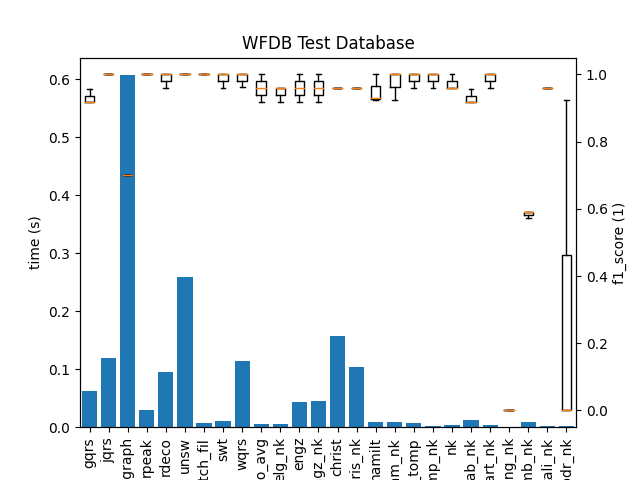

In [31]:
for database in databases:
    print('Database: ',database.Name)
    runtime = [[] for i in range(len(detectors))]
    sensitivity = [[] for i in range(len(detectors))]
    positive_predictivity = [[] for i in range(len(detectors))]
    f1_score = [[] for i in range(len(detectors))]
    for user in database.Users:
        print('User: ',user.UserName)
        for recording in user.Recordings:
            print('Recording: ',recording.RecordingName)
            for recordingsegment in recording.RecordingSegments:
                evaluations = recordingsegment.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)
                for i in range(len(evaluations)):
                    runtime[i].append(evaluations[i].runtime)
                    sensitivity[i].append(evaluations[i].sensitivity)
                    positive_predictivity[i].append(evaluations[i].positive_predictivity)
                    f1_score[i].append(evaluations[i].f1_score)

    data = [np.around([np.mean(time) for time in runtime],decimals=2),np.around([np.min(sens) for sens in sensitivity],decimals=2), np.around([np.min(pos_pred) for pos_pred in positive_predictivity],decimals=2),np.around([np.min(f1) for f1 in f1_score],decimals=2)]
    rows = ["runtime (s)","sensitiv", "pos pred", "f1 score"]
    columns = [detector.short_name for detector in detectors]

    print(pandas.DataFrame(data, rows, columns))

    fig, ax = plt.subplots()
    ax.bar(range(1, len(runtime)+1),[np.mean(time) for time in runtime])
    ax.set_ylabel("time (s)")
    ax2 = ax.twinx()
    ax2.boxplot(f1_score)
    ax2.set_ylabel("f1_score (1)")
    ax.set_xticklabels(columns, rotation = 'vertical')
    ax.set_title(database.Name) 
    ax.set_xlabel("detectors")          

In [32]:
name = databases[0].Name
recording = databases[0].Users[0].Recordings[0]
signal = recording.WholeSignal
actual_qrs_complexes = recording.WholeActual_Qrs_Complex
evaluations = recording.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)

rodr_nk failed due to an index error and was skipped


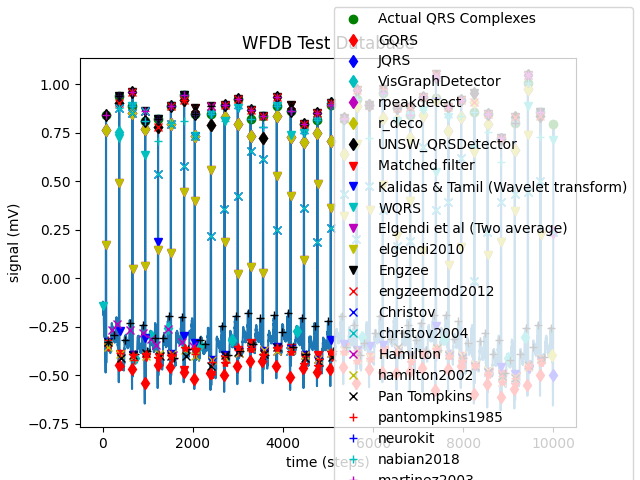

In [33]:
markers = ["d", "v", "x", "+", "*", "^", "<", ">", "1", "2", "3", "4", "8", "s","p", "P", "h", "H", "X", "D", "|", "_", ".", "o"]
colors = ["r", "b", "c", "m", "y", "k"]

fmt = [marker + color for marker in markers for color in colors]

#fmt = ['bo','r<','c^','m>','yv','rx','kd','cp','cx','b>','yx','mx','bx', 'rd', 'r0']
fig, ax = plt.subplots(1)
ax.plot(signal)
ax.plot(actual_qrs_complexes, signal[actual_qrs_complexes], 'go', label = "Actual QRS Complexes")
for i in range(len(evaluations)):
    ax.plot(evaluations[i].predicted_peaks, signal[evaluations[i].predicted_peaks], fmt[i],label=evaluations[i].Detector.name)
ax.set_title(name)
ax.set_xlabel("time (steps)")
ax.set_ylabel("signal (mV)")

fig.legend()

## Tests

[-0.145 -0.145 -0.145 ... -0.395 -0.39  -0.4  ]
[-0.145 -0.145 -0.145 ...  0.71   0.795  0.72 ]
[-0.145 -0.145 -0.145 ... -0.395 -0.39  -0.4  ]
360
[ 369  664  947 1233 1516 1807 2043 2399 2703 2995 3281 3558]


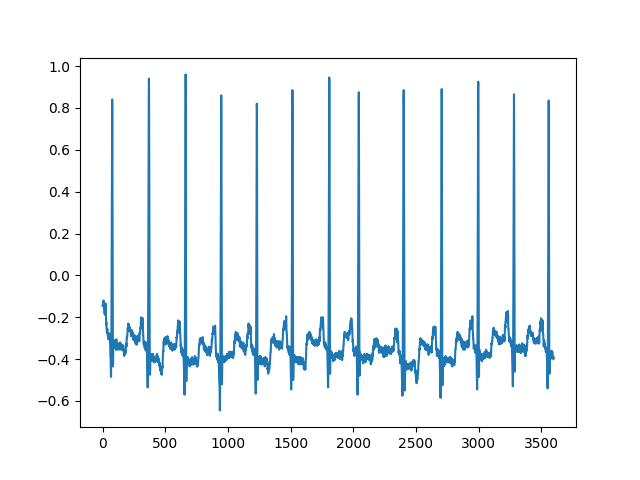

In [35]:
test = databases[0].Users[0].Recordings[0].RecordingSegments[0]
test1 = databases[0].Users[0].Recordings[0]
signal = test.Signal
print(signal)
fs = test.Fs
signal = test1.WholeSignal
print(signal)
fs = test1.Fs

signal = test.Signal
print(signal)

plt.figure()
plt.plot(signal)

#data = test.Evaluation([detectors[4]], predict_peaks, binary_classification, score_calculation)
envelope_size = 300.0 # envelope size in ms, default = 300.0
average_heart_rate = 100.0 # average heart rate in bpm, default = 100.0
post_processing = 1.0 # post processing where 1.0 means yes, default = 1.0
ectopic_removal = 0.0 # ectopic removal where 1.0 means yes, default = 0.0
inverted_signal = 0.0 # inverted signal where 1.0 means yes, default = 0.0
parameters_check = 0.0 # parameters check in UI where 1.0 means yes, default = 0.0
newsignal = [[i] for i in signal]
#print(newsignal)
print(test.Fs)
#data = eng.peak_detection([envelope_size,average_heart_rate,post_processing,ectopic_removal,inverted_signal],matlab.double(newsignal), matlab.double(fs),parameters_check)
data = run_christov2004(signal,fs)
print(data)

# Experiment 1 - Performance on synthetic data
## Signal generation

In [250]:
signal_generator_path = eng.genpath('C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code\Signal_generator')
eng.addpath(signal_generator_path)

rrLength_array = [50]        # A desired ECG signal length (the number of RR intervals) 
APBrate_array = [0.10, 0.2, 0.25]      # Rate of atrial premature beats (APB). A number between 0 and 0.5
onlyRR_array = [0]          # 1 - only RR intervals are generated, 0 - multilead ECG is generated

medEpis_array = [15]        # Median duration of an atrial fibrillation (AF) episode
stayInAF_array = 1-np.log(2)/medEpis_array   # Probability to stay in AF state
AFburden_array = [0.8]      # AF burden. 0 - the entire signal is sinus rhythm (SR), 1 - the entire signal is AF

noiseType_array = [0, 1, 2, 3]       # Type of noise. A number from 0 to 4. 0 - no noise added (noise RMS = 0 mV), 
                            # 1 - motion artefacts, 2 - electrode movement artefacts, 3 - baseline wander, 
                            # 4 - mixture of type 1, type 2 and type 3 noises
noiseRMS_array = [0.001, 0.01,0.5]     # Noise level in milivolts 

realRRon_array = [1]        # 1 - real RR series are used, 0 - synthetic
realVAon_array = [0]       # 1 - real ventricular activity is used, 0 - synthetic
realAAon_array = [0]        # 1 - real atrial activity is used, 0 - synthetic

synthetic_signals = eng.Adapted_simPAF_ECG_generator_iterator(matlab.double(rrLength_array),matlab.double(APBrate_array),matlab.double(onlyRR_array),matlab.double(medEpis_array),matlab.double(stayInAF_array),matlab.double(AFburden_array),matlab.double(noiseType_array),matlab.double(noiseRMS_array),matlab.double(realRRon_array),matlab.double(realVAon_array),matlab.double(realAAon_array))

In [251]:
synth_fs = 500
users = []
recordings = []
for i  in range(len(synthetic_signals)):
    synthetic_signal = synthetic_signals['s'+str(i+1)]
    recordingsegments = []
    signal = np.transpose(np.array(synthetic_signal['multileadECG'])[0])
    actual_qrs_complexes = np.transpose(np.array(synthetic_signal['QRSindex'])[0]).astype(int)
    
    splits = split_signal(signal=signal,fs=synth_fs, actual_qrs_complexes=np.array(actual_qrs_complexes).astype(int))
    
    for split in splits:
        recordingsegments.append(RecordingSegment(Signal=split[0], Actual_Qrs_Complex=split[1], Fs=synth_fs))
    recordings.append(Recording(RecordingName="default",RecordingSegments = recordingsegments,WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=synth_fs))
users.append(User(UserName="default",Recordings = recordings))   
        
synth_whole_database = Database(
    Name="Whole Synthetic Database",
    Users=users,
    Fs=synth_fs)

Database:  Whole Synthetic Database
User:  default
Recording:  default
match_fil could not run because the sample rate is wrong and was skipped
Recording:  default
match_fil could not run because the sample rate is wrong and was skipped
Recording:  default
jqrs failed due to an index error and was skipped
match_fil could not run because the sample rate is wrong and was skipped
Recording:  default
jqrs failed due to an index error and was skipped
match_fil could not run because the sample rate is wrong and was skipped
Recording:  default
match_fil could not run because the sample rate is wrong and was skipped
Recording:  default
match_fil could not run because the sample rate is wrong and was skipped
Recording:  default
match_fil could not run because the sample rate is wrong and was skipped
Recording:  default
match_fil could not run because the sample rate is wrong and was skipped
Recording:  default
match_fil could not run because the sample rate is wrong and was skipped
Recording:  

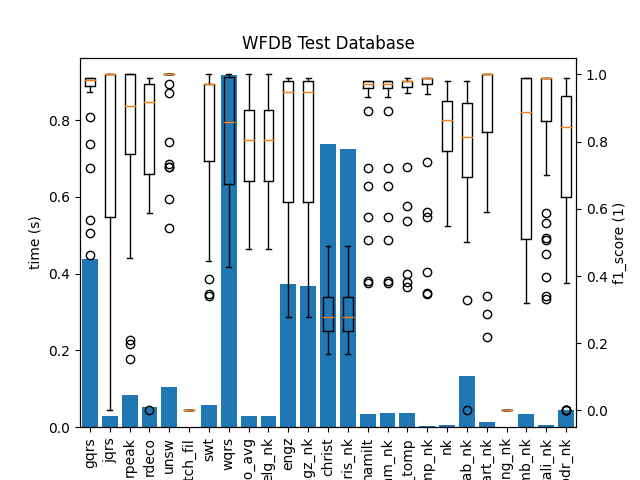

In [252]:

print('Database: ',synth_whole_database.Name)
runtime = [[] for i in range(len(detectors))]
sensitivity = [[] for i in range(len(detectors))]
positive_predictivity = [[] for i in range(len(detectors))]
f1_score = [[] for i in range(len(detectors))]
features = [[[] for j in range(len(synthetic_signals))] for i in range(len(detectors))]

cnt = 0
for user in synth_whole_database.Users:
    print('User: ',user.UserName)
    for recording in user.Recordings:

        synthetic_signal = synthetic_signals['s'+str(cnt+1)]

        print('Recording: ',recording.RecordingName)
        evaluations = recording.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)
        for i in range(len(evaluations)):
            runtime[i].append(evaluations[i].runtime)
            sensitivity[i].append(evaluations[i].sensitivity)
            positive_predictivity[i].append(evaluations[i].positive_predictivity)
            f1_score[i].append(evaluations[i].f1_score)
            
            features[i][cnt] = [synthetic_signal['ip_noiseType'], synthetic_signal['ip_noiseRMS'], synthetic_signal['ip_APBrate'], evaluations[i].f1_score]
            
        cnt = cnt + 1

    data = [np.around([np.mean(time) for time in runtime],decimals=2),np.around([np.min(sens) for sens in sensitivity],decimals=2), np.around([np.min(pos_pred) for pos_pred in positive_predictivity],decimals=2),np.around([np.min(f1) for f1 in f1_score],decimals=2)]
    rows = ["runtime (s)","sensitiv", "pos pred", "f1 score"]
    columns = [detector.short_name for detector in detectors]

    print(pandas.DataFrame(data, rows, columns))

    fig, ax = plt.subplots()
    ax.bar(range(1, len(runtime)+1),[np.mean(time) for time in runtime])
    ax.set_ylabel("time (s)")
    ax2 = ax.twinx()
    ax2.boxplot(f1_score)
    ax2.set_ylabel("f1_score (1)")
    ax.set_xticklabels(columns, rotation = 'vertical')
    ax.set_title(database.Name) 
    ax.set_xlabel("detectors")      

In [253]:
# counter = 0
# f1_score_multidim = [[[[[[[[[[0 for a in range(len(realVAon_array))] for b in range(len(realRRon_array))] for d in range(len(noiseRMS_array))] for e in range(len(noiseType_array))] for f in range(len(AFburden_array))] for h in range(len(stayInAF_array))] for i in range(len(medEpis_array))] for j in range(len(onlyRR_array))] for k in range(len(APBrate_array))] for l in range(len(rrLength_array))]
# for rrLength in range(len(rrLength_array)):
#     for APBrate in range(len(APBrate_array)):
#         for onlyRR in range(len(onlyRR_array)):
#             for medEpis in range(len(medEpis_array)):
#                 for stayInAF in range(len(stayInAF_array)):
#                     for AFburden in range(len(AFburden_array)):
#                         for noiseType in range(len(noiseType_array)):
#                             for noiseRMS in range(len(noiseRMS_array)):
#                                 for realRRon in range(len(realRRon_array)):
#                                     for realVAon in range(len(realVAon_array)):
#                                         f1_score_multidim[rrLength][APBrate][onlyRR][medEpis][stayInAF][AFburden][noiseType][noiseRMS][realRRon][realVAon] = f1_score[0][counter]
#                                         counter = counter + 1

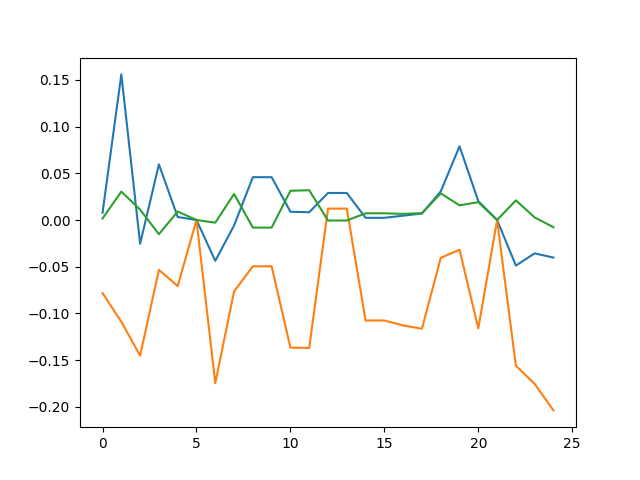

In [291]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

data = []
for feature in features:
    feature = np.array(feature)
    x = feature[:,0:3]
    y = feature[:,3]
    model = LinearRegression()
    model.fit(StandardScaler().fit_transform(x),y)
    data.append(model.coef_)

fig, ax = plt.subplots()
ax.plot(data)

In [267]:
from sklearn.preprocessing import StandardScaler


feature = np.array(features[1])

x = feature[:,0:3]
y = feature[:,3]




In [286]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(StandardScaler().fit_transform(x),y)
print(model.coef_)


[ 0.15597568 -0.10899871  0.03046967]


In [279]:
x_new = x - np.mean(x)
x_new = x_new / np.std(x_new)
#x_new = StandardScaler().fit_transform(x)
covariance = np.cov(x_new.T)
w, v = np.linalg.eigh(covariance)
print(covariance)
print(w)
print(v)

[[ 1.55812240e+00 -9.95178548e-19 -1.75189946e-18]
 [-9.95178548e-19  6.77515941e-02 -2.71704476e-19]
 [-1.75189946e-18 -2.71704476e-19  4.84749192e-03]]
[0.00484749 0.06775159 1.5581224 ]
[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.11022302e-16 -1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  2.22044605e-16  0.00000000e+00]]


In [256]:
x = StandardScaler().fit_transform(x)

In [257]:
print(x)
print(y)

[[-1.34164079 -0.72632079 -1.33630621]
 [-1.34164079 -0.68771713 -1.33630621]
 [-1.34164079  1.41403792 -1.33630621]
 [-0.4472136  -0.72632079 -1.33630621]
 [-0.4472136  -0.68771713 -1.33630621]
 [-0.4472136   1.41403792 -1.33630621]
 [ 0.4472136  -0.72632079 -1.33630621]
 [ 0.4472136  -0.68771713 -1.33630621]
 [ 0.4472136   1.41403792 -1.33630621]
 [ 1.34164079 -0.72632079 -1.33630621]
 [ 1.34164079 -0.68771713 -1.33630621]
 [ 1.34164079  1.41403792 -1.33630621]
 [-1.34164079 -0.72632079  0.26726124]
 [-1.34164079 -0.68771713  0.26726124]
 [-1.34164079  1.41403792  0.26726124]
 [-0.4472136  -0.72632079  0.26726124]
 [-0.4472136  -0.68771713  0.26726124]
 [-0.4472136   1.41403792  0.26726124]
 [ 0.4472136  -0.72632079  0.26726124]
 [ 0.4472136  -0.68771713  0.26726124]
 [ 0.4472136   1.41403792  0.26726124]
 [ 1.34164079 -0.72632079  0.26726124]
 [ 1.34164079 -0.68771713  0.26726124]
 [ 1.34164079  1.41403792  0.26726124]
 [-1.34164079 -0.72632079  1.06904497]
 [-1.34164079 -0.68771713

In [258]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

principalDf = pandas.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pandas.concat([principalDf, pandas.DataFrame(data=y,columns=['target'])], axis = 1)


In [259]:
pca.get_feature_names_out(input_features=['a', 'b', 'c'])
pca.get_covariance()

array([[1.02857143, 0.        , 0.        ],
       [0.        , 1.02857143, 0.        ],
       [0.        , 0.        , 1.02857143]])

In [260]:
pca.explained_variance_ratio_

array([0.33333333, 0.33333333])

In [261]:
print(finalDf)

    principal component 1  principal component 2    target
0               -0.726321               1.341641  1.000000
1               -0.687717               1.341641  1.000000
2                1.414038               1.341641  0.000000
3               -0.726321               0.447214  0.000000
4               -0.687717               0.447214  1.000000
5                1.414038               0.447214  0.320000
6               -0.726321              -0.447214  1.000000
7               -0.687717              -0.447214  1.000000
8                1.414038              -0.447214  0.630631
9               -0.726321              -1.341641  1.000000
10              -0.687717              -1.341641  1.000000
11               1.414038              -1.341641  0.990099
12              -0.726321               1.341641  1.000000
13              -0.687717               1.341641  0.000000
14               1.414038               1.341641  0.000000
15              -0.726321               0.447214  0.9900

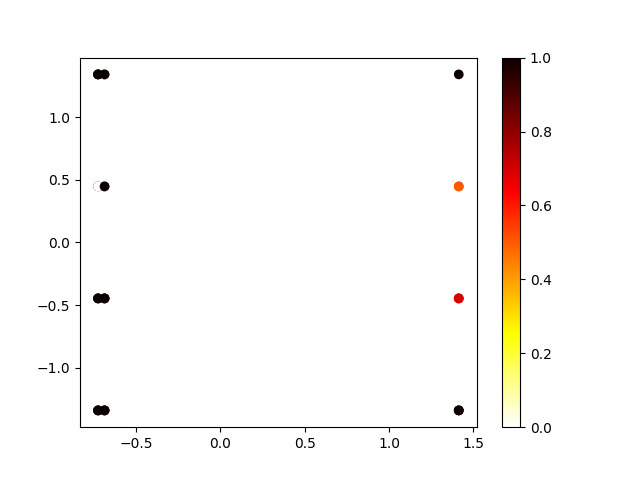

In [262]:
plt.figure()
plt.scatter(x=principalComponents[:,0], y=principalComponents[:,1],cmap=plt.cm.hot_r, c=y)
plt.colorbar()

In [280]:
pca.coef_

AttributeError: 'PCA' object has no attribute 'coef_'

In [264]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
flat = np.matrix.flatten(np.array(f1_score_multidim))
test = np.cov(flat)
principalComponents = pca.fit_transform(flat.reshape(1, -1))

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

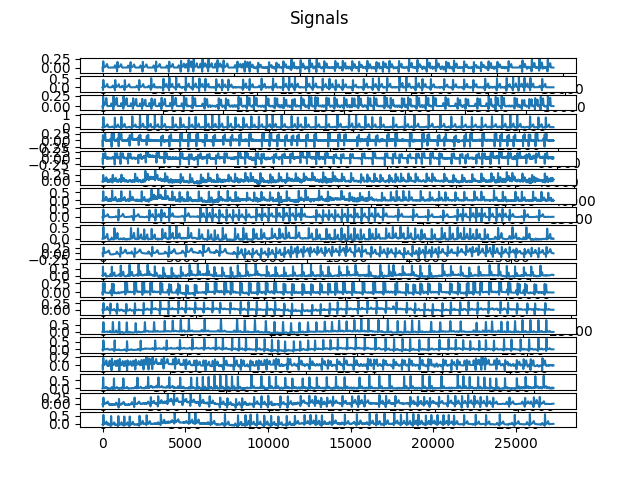

In [ ]:
fig, axs = plt.subplots(len(synthetic_signals))
fig.suptitle('Signals')
for i  in range(len(synthetic_signals)):
    axs[i].plot(np.transpose(np.array(synthetic_signals['s'+str(i+1)]['multileadECG'])[0]))